In [2]:
print("aa")

aa


In [3]:
import sys
sys.path.append('/home/dylan-kmutt/ubpd')

In [4]:
from src.helper import get_train_test_pids

train_v_pids, test_pids = get_train_test_pids("../../data/dataset/images/", seed=42)
all_pids = train_v_pids + test_pids
len(all_pids)

88

In [5]:
from typing import List, Tuple
import random
import math

def split_train_and_test(pids: List[int], seed: int = 42) -> Tuple[List[int], List[int]]:
    if not pids:
        return [], []

    # De-duplicate while preserving order
    unique = list(dict.fromkeys(pids))
    n = len(unique)

    # Reproducible shuffle
    rng = random.Random(seed)
    idxs = list(range(n))
    rng.shuffle(idxs)
    shuffled = [unique[i] for i in idxs]

    # Compute test size (≈15%); keep at least 1 test if possible, and at least 1 train
    raw_test = int(round(n * 0.15))
    if n >= 2:
        test_size = max(1, min(raw_test, n - 1))
    else:
        test_size = 0  # only one item → all train

    test_ids = shuffled[:test_size]
    train_ids = shuffled[test_size:]

    return train_ids, test_ids


In [6]:
ultrasound_1_pids = [i for i in range(7, 44+1) if i in all_pids]

sub_1_ultrasound_2_pids = [i for i in range(47, 166+1) if i in all_pids]
sub_2_ultrasound_2_pids = [i for i in range(1, 6+1) if i in all_pids]
ultrasound_2_pids = sub_1_ultrasound_2_pids + sub_2_ultrasound_2_pids

print(f"# Patients in Ultrasound 1: {len(ultrasound_1_pids)}")
print(f"# Patients in Ultrasound 2: {len(ultrasound_2_pids)}")

# Patients in Ultrasound 1: 36
# Patients in Ultrasound 2: 52


In [13]:
seed = 94
u1_train_pids, u1_test_pids = split_train_and_test(ultrasound_1_pids, seed=seed)
u2_train_pids, u2_test_pids = split_train_and_test(ultrasound_2_pids, seed=seed)

# Combine (concat) and deduplicate while keeping order
comb_train_pids = list(dict.fromkeys(list(u1_train_pids) + list(u2_train_pids)))
comb_test_pids  = list(dict.fromkeys(list(u1_test_pids)  + list(u2_test_pids)))

# Optional: ensure no leakage between train/test
leak = set(comb_train_pids) & set(comb_test_pids)
if leak:
    comb_train_pids = [p for p in comb_train_pids if p not in leak]
    print("leak")
    # or raise an error/log, depending on your policy

print(f"Seed: {seed}\n")
print(f"Ultrasound 1: train {len(u1_train_pids)} pids, test {len(u1_test_pids)} pids")
print(f"  Train PIDs: {', '.join(map(str, u1_train_pids))}")
print(f"  Test  PIDs: {', '.join(map(str, u1_test_pids))}\n")

print(f"Ultrasound 2: train {len(u2_train_pids)} pids, test {len(u2_test_pids)} pids")
print(f"  Train PIDs: {', '.join(map(str, u2_train_pids))}")
print(f"  Test  PIDs: {', '.join(map(str, u2_test_pids))}\n")

print(f"Combined: train {len(comb_train_pids)} pids, test {len(comb_test_pids)} pids")
print(f"  Train PIDs: {', '.join(map(str, comb_train_pids))}")
print(f"  Test  PIDs: {', '.join(map(str, comb_test_pids))}")

Seed: 94

Ultrasound 1: train 31 pids, test 5 pids
  Train PIDs: 19, 38, 23, 13, 28, 17, 10, 12, 42, 21, 34, 25, 30, 31, 37, 41, 15, 40, 39, 16, 44, 22, 29, 7, 36, 20, 27, 24, 14, 18, 43
  Test  PIDs: 11, 35, 32, 9, 8

Ultrasound 2: train 44 pids, test 8 pids
  Train PIDs: 93, 85, 83, 88, 64, 131, 78, 87, 67, 61, 49, 51, 60, 52, 73, 66, 65, 92, 99, 75, 53, 79, 5, 84, 76, 90, 47, 97, 166, 6, 3, 94, 1, 2, 77, 86, 100, 48, 82, 71, 69, 58, 63, 89
  Test  PIDs: 50, 62, 98, 4, 81, 96, 70, 68

Combined: train 75 pids, test 13 pids
  Train PIDs: 19, 38, 23, 13, 28, 17, 10, 12, 42, 21, 34, 25, 30, 31, 37, 41, 15, 40, 39, 16, 44, 22, 29, 7, 36, 20, 27, 24, 14, 18, 43, 93, 85, 83, 88, 64, 131, 78, 87, 67, 61, 49, 51, 60, 52, 73, 66, 65, 92, 99, 75, 53, 79, 5, 84, 76, 90, 47, 97, 166, 6, 3, 94, 1, 2, 77, 86, 100, 48, 82, 71, 69, 58, 63, 89
  Test  PIDs: 11, 35, 32, 9, 8, 50, 62, 98, 4, 81, 96, 70, 68


In [30]:
def report_leak(tag, train_ids, test_ids):
    leak = set(train_ids) & set(test_ids)
    if leak:
        print(f"[LEAK] {tag}: {len(leak)} overlapping PID(s): {', '.join(map(str, sorted(leak)))}")
    else:
        print(f"[OK]   {tag}: no leakage.")

# Per-dataset leakage
report_leak("Ultrasound 1", u1_train_pids, u1_test_pids)
report_leak("Ultrasound 2", u2_train_pids, u2_test_pids)

# Cross-dataset leakage (train of one vs test of the other)
report_leak("U1 train vs U2 test", u1_train_pids, u2_test_pids)
report_leak("U2 train vs U1 test", u2_train_pids, u1_test_pids)

# Combined leakage
report_leak("Combined", comb_train_pids, comb_test_pids)

[OK]   Ultrasound 1: no leakage.
[OK]   Ultrasound 2: no leakage.
[OK]   U1 train vs U2 test: no leakage.
[OK]   U2 train vs U1 test: no leakage.
[OK]   Combined: no leakage.


In [20]:
from src.helper import get_cv_pids

u1_cv_pids = get_cv_pids(u1_train_pids, cv=5)
u2_cv_pids = get_cv_pids(u2_train_pids, cv=5)

In [21]:
assert len(u1_cv_pids) == len(u2_cv_pids), "U1 and U2 must have the same # of folds"

comb_cv_pids: list[tuple[list[int], list[int]]] = []
for (u1_tr, u1_val), (u2_tr, u2_val) in zip(u1_cv_pids, u2_cv_pids):
    # concat + dedup while keeping order
    comb_tr  = list(dict.fromkeys(list(u1_tr)  + list(u2_tr)))
    comb_val = list(dict.fromkeys(list(u1_val) + list(u2_val)))

    # optional: sanity check for leakage within the fold
    leak = set(comb_tr) & set(comb_val)
    if leak:
        print(f"[LEAK] Combined fold has overlap: {sorted(leak)}")

    comb_cv_pids.append((comb_tr, comb_val))


In [22]:
def print_cv(name: str, cv_pids: list[tuple[list[int], list[int]]]) -> None:
    print(f"{name}: {len(cv_pids)} folds")
    for i, (train, val) in enumerate(cv_pids, start=1):
        print(f" Fold {i}: train {len(train)} pids, val {len(val)} pids")
        print(f"   Train: {', '.join(map(str, train))}")
        print(f"   Val  : {', '.join(map(str, val))}")
        leak = set(train) & set(val)
        if leak:
            print(f"   [LEAK] {len(leak)} overlapping PID(s): {', '.join(map(str, sorted(leak)))}")
    print()

print_cv("Ultrasound 1 (CV)", u1_cv_pids)
print_cv("Ultrasound 2 (CV)", u2_cv_pids)
print_cv("Combined (CV)", comb_cv_pids)


Ultrasound 1 (CV): 5 folds
 Fold 1: train 25 pids, val 6 pids
   Train: 17, 30, 25, 41, 21, 27, 43, 29, 15, 14, 38, 31, 39, 23, 40, 22, 18, 28, 20, 12, 42, 7, 19, 13, 44
   Val  : 16, 37, 34, 36, 24, 10
 Fold 2: train 25 pids, val 6 pids
   Train: 16, 37, 34, 36, 24, 10, 43, 29, 15, 14, 38, 31, 39, 23, 40, 22, 18, 28, 20, 12, 42, 7, 19, 13, 44
   Val  : 17, 30, 25, 41, 21, 27
 Fold 3: train 25 pids, val 6 pids
   Train: 16, 37, 34, 36, 24, 10, 17, 30, 25, 41, 21, 27, 39, 23, 40, 22, 18, 28, 20, 12, 42, 7, 19, 13, 44
   Val  : 43, 29, 15, 14, 38, 31
 Fold 4: train 25 pids, val 6 pids
   Train: 16, 37, 34, 36, 24, 10, 17, 30, 25, 41, 21, 27, 43, 29, 15, 14, 38, 31, 20, 12, 42, 7, 19, 13, 44
   Val  : 39, 23, 40, 22, 18, 28
 Fold 5: train 24 pids, val 7 pids
   Train: 16, 37, 34, 36, 24, 10, 17, 30, 25, 41, 21, 27, 43, 29, 15, 14, 38, 31, 39, 23, 40, 22, 18, 28
   Val  : 20, 12, 42, 7, 19, 13, 44

Ultrasound 2 (CV): 5 folds
 Fold 1: train 36 pids, val 8 pids
   Train: 64, 86, 84, 51, 3, 7

In [ ]:
def get_pids(seed, ultrasound):
    if seed == 42:
        if ultrasound == "u1":
            p_ids = [16, 19, 12, 36, 41]
        if ultrasound == "u2":
            p_ids = [61, 77, 79, 50, 75, 94, 68, 96]
        if ultrasound == "combined":
            p_ids = [16, 19, 12, 36, 41, 61, 77, 79, 50, 75, 94, 68, 96]
    elif seed == 94:
        if ultrasound == "u1":
            p_ids = [11, 35, 32, 9, 8]
        if ultrasound == "u2":
            p_ids = [50, 62, 98, 4, 81, 96, 70, 68]
        if ultrasound == "combined":
            p_ids = [11, 35, 32, 9, 8, 50, 62, 98, 4, 81, 96, 70, 68]
    elif seed == 33:
        if ultrasound == "u1":
            p_ids = [38, 19, 10, 42, 8]
        if ultrasound == "u2":
            p_ids = [131, 53, 6, 47, 78, 49, 76, 64]
        if ultrasound == "combined":
            p_ids = [38, 19, 10, 42, 8, 131, 53, 6, 47, 78, 49, 76, 64]
    return p_ids

In [26]:
import numpy as np
import os
import wandb

from src.dataset import UBPDataset
from src.preprocessing import PairedTransform
from src.dataset import UBPDataset
from src.preprocessing import PairedTransform
from src.train import Trainer
from src.evaluate import Evaluator
from src.helper import (
    set_seed,
    _build_model_factory,
    aggregate_fold_metrics,
)

def experiment(variants, exp_id, seed):
    # CV
    exp_id = str(exp_id)
    all_histories = []
    fold_overall_means = []
    fold_results = []  # store per-fold evaluator outputs (dicts)

    # exp_id = random.randint(int(1e5), int(1e6) - 1)
    model_name = variants["model"]

    set_seed(seed)
    print(f"\n🚀 Beginning experiment #{exp_id}")
    print("=" * 60)

    include_classes = variants.get("include_classes")
    class_names = {
        1: "dongmai (artery)",
        2: "jingmai (vein)",
        3: "jirouzuzhi (muscle)",
        4: "shenjing (nerve)",
    }
    print("Included classes:")
    for cid in include_classes:
        print(f"  {cid}: {class_names.get(cid, 'unknown')}")
    print(f"\n- Model: {model_name}")
    print(f"- Augment: {variants['augment']}")

    include_classes = variants["include_classes"]
    n_inc = len(include_classes)
    if n_inc == 1:
        variants["loss"] = "bce"
        num_classes_for_model = 1  # single foreground channel
        keep_original_indices = True  # irrelevant when binary
    else:
        variants["loss"] = "ce"
        num_classes_for_model = n_inc + 1  # background + selected classes only
        keep_original_indices = False  # remap selected IDs to contiguous {0..K}
    variants["num_classes"] = num_classes_for_model

    print(
        f"- Using loss='{variants['loss']}' with model num_classes={num_classes_for_model}"
    )
    if not keep_original_indices:
        print(
            "- Remapping labels to contiguous IDs: background=0, selected classes=1..K"
        )
    print(f"- Image size: {variants['image_size']}")
    print("-" * 60)

    if variants["dataset"] == "u1":
        test_pids = u1_test_pids
        cv_pids = u1_cv_pids
    if variants["dataset"] == "u2":
        test_pids = u2_test_pids
        cv_pids = u2_cv_pids
    if variants["dataset"] == "comb":
        test_pids = comb_test_pids
        cv_pids = comb_cv_pids

    paired_train_tf = PairedTransform(size=variants["image_size"], aug=variants["augment"])
    paired_test_tf = PairedTransform(size=variants["image_size"], aug=False)
    test_dataset = UBPDataset(
        p_ids=test_pids,
        include_classes=include_classes,
        image_dir="../../data/dataset/images",
        json_dir="../../data/dataset/labels/json_train",
        joint_transform=paired_test_tf,
        keep_original_indices=True,
    )

    print("Test landmarks stat: ")
    test_dataset.print_stats()
    len(test_dataset)

    for fold in range(1, len(cv_pids)+1):
        name = f"{exp_id}_fold_{fold}"
        if variants["use_wandb"]:
            api_key = os.getenv("WANDB_API_KEY")
            wandb.login(key=api_key)
            wandb.init(
                project="ubpd",
                group=exp_id,
                name=name,
                config=variants,
                reinit=True,
            )
        train_pids, val_pids = cv_pids[fold-1]

        print(f"\n📂 Fold {fold}/{len(cv_pids)}")
        print(f"  Train patient IDs: {train_pids}")
        print(f"  Val   patient IDs: {val_pids}\n")

        train_dataset = UBPDataset(
            p_ids=train_pids,
            include_classes=include_classes,
            image_dir="../../data/dataset/images",
            json_dir="../../data/dataset/labels/json_train",
            joint_transform=paired_train_tf,
            keep_original_indices=keep_original_indices,  # <--- important
        )

        val_dataset = UBPDataset(
            p_ids=val_pids,
            include_classes=include_classes,
            image_dir="../../data/dataset/images",
            json_dir="../../data/dataset/labels/json_train",
            joint_transform=paired_test_tf,
            keep_original_indices=keep_original_indices,  # <--- important
        )

        print("Train landmarks stat: ")
        train_dataset.print_stats()
        print()
        print("Validation landmarks stat:")
        val_dataset.print_stats()
        val_dataset.visualize_image_transform(0)

        make_model = _build_model_factory(model_name)
        model = make_model(num_classes=num_classes_for_model)

        trainer = Trainer(
            exp_id=exp_id,
            fold_num=fold,
            model=model,
            train_dataset=train_dataset,
            val_dataset=val_dataset,
            arguments=variants,
        )
        history = trainer.train()
        all_histories.append(history)

        if history["val_loss"]:
            best_idx = int(np.argmin(history["val_loss"]))
            print(
                f"  ✅ Best @ epoch {best_idx+1}: val_loss={history['val_loss'][best_idx]:.4f} | val_dice={history['val_dice'][best_idx]:.4f}"
            )
        print("-" * 60)

        # Evaluate one fold (you can move this after the loop to evaluate the final/best model instead)
        evaluator = Evaluator(
            trainer.model,
            test_dataset,
            num_classes=num_classes_for_model,
            ignore_empty_classes=False,
        )
        res = evaluator.evaluate_dice_score(show_plot=True)
        evaluator.visualize_ranked()
                # collect overall mean dice for this fold if available
        try:
            overall_mean = res.get("overall", {}).get("mean", float("nan"))
        except Exception:
            overall_mean = float("nan")
        fold_overall_means.append(
            float(overall_mean) if overall_mean is not None else float("nan")
        )
        fold_results.append(res)

    overall_mean, overall_std, per_class_stats = aggregate_fold_metrics(fold_results)
    if not np.isnan(overall_mean):
        print(
            f"\n🎯 Average overall Dice across folds: {overall_mean:.4f} ± {overall_std:.4f}  (n={len(fold_results)})"
        )
    else:
        print("\n⚠️ No per-fold overall Dice scores collected.")

    # Print per-landmark (per-class) averages
    if per_class_stats:
        print("\n📌 Per-landmark average Dice across folds:")
        for cid in sorted(per_class_stats.keys()):
            stats = per_class_stats[cid]
            name = class_names.get(cid, f"class_{cid}")
            print(
                f"  {cid}: {name:<20s} mean±std: {stats['mean']:.4f} ± {stats['std']:.4f}  (folds={stats['n_folds']})"
            )
    else:
        print("\n⚠️ No per-class stats available to aggregate.")

    print("\n✅ Experiment complete across folds.")

    if variants["use_wandb"]:
        wandb.finish()
        
    return {
        "histories": all_histories,
        "test_dataset": test_dataset,
        "fold_overall_means": fold_overall_means,
    }


In [35]:
import torch

variants = {
    "model": "unet",
    "cv": 5,
    "include_classes": [1,2,3,4],
    "dataset": "comb",

    "epochs": 100,
    "batch_size": 16,
    "num_workers": 2,
    "image_size": 512,
    
    "patience": 20,
    "scheduler": "plateau",
    "plateau_cooldown": 10,
    
    "half_precision": True,
    "ignore_empty": False,
    "augment": True,
    "cuda": "cuda" if torch.cuda.is_available() else "cpu",
    "use_wandb": True,
    "save_dir": "../../checkpoints"
}

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/dylan-kmutt/.netrc



🚀 Beginning experiment #909994
Included classes:
  1: dongmai (artery)
  2: jingmai (vein)
  3: jirouzuzhi (muscle)
  4: shenjing (nerve)

- Model: unet
- Augment: True
- Using loss='ce' with model num_classes=5
- Remapping labels to contiguous IDs: background=0, selected classes=1..K
- Image size: 512
------------------------------------------------------------
Test landmarks stat: 
Artery  present:  98/147 images
Vein    present:  83/147 images
Muscle  present: 101/147 images
Nerve   present: 137/147 images



📂 Fold 1/5
  Train patient IDs: [17, 30, 25, 41, 21, 27, 43, 29, 15, 14, 38, 31, 39, 23, 40, 22, 18, 28, 20, 12, 42, 7, 19, 13, 44, 64, 86, 84, 51, 3, 79, 60, 90, 48, 82, 166, 52, 76, 53, 5, 6, 89, 93, 75, 65, 63, 100, 1, 58, 83, 97, 131, 77, 78, 67, 73, 66, 92, 85, 87, 69]
  Val   patient IDs: [16, 37, 34, 36, 24, 10, 61, 88, 49, 2, 71, 99, 94, 47]

Train landmarks stat: 
Artery  present: 393/661 images
Vein    present: 389/661 images
Muscle  present: 569/661 images
Nerve   present: 631/661 images

Validation landmarks stat:
Artery  present:  87/147 images
Vein    present:  93/147 images
Muscle  present:  79/147 images
Nerve   present: 129/147 images


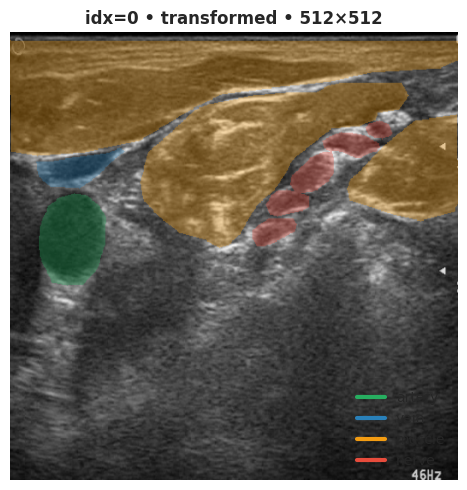

Epoch 001/100 | lr=1.000e-03 train_loss=1.0045 val_loss=0.6016 train_dice=0.1055 val_dice=0.1640 [BEST] (patience 0/20)
Epoch 002/100 | lr=1.000e-03 train_loss=0.5932 val_loss=0.7193 train_dice=0.2229 val_dice=0.2144  (patience 1/20)
Epoch 003/100 | lr=1.000e-03 train_loss=0.4583 val_loss=0.4158 train_dice=0.2946 val_dice=0.2151 [BEST] (patience 0/20)
Epoch 004/100 | lr=1.000e-03 train_loss=0.4209 val_loss=0.3553 train_dice=0.3026 val_dice=0.2430 [BEST] (patience 0/20)
Epoch 005/100 | lr=1.000e-03 train_loss=0.3899 val_loss=0.3478 train_dice=0.2996 val_dice=0.2765 [BEST] (patience 0/20)
Epoch 006/100 | lr=1.000e-03 train_loss=0.3523 val_loss=0.3683 train_dice=0.2690 val_dice=0.1745  (patience 1/20)
Epoch 007/100 | lr=1.000e-03 train_loss=0.3305 val_loss=0.3606 train_dice=0.2609 val_dice=0.2043  (patience 2/20)
Epoch 008/100 | lr=1.000e-03 train_loss=0.3198 val_loss=0.3055 train_dice=0.2556 val_dice=0.2877 [BEST] (patience 0/20)
Epoch 009/100 | lr=1.000e-03 train_loss=0.2911 val_loss=0.

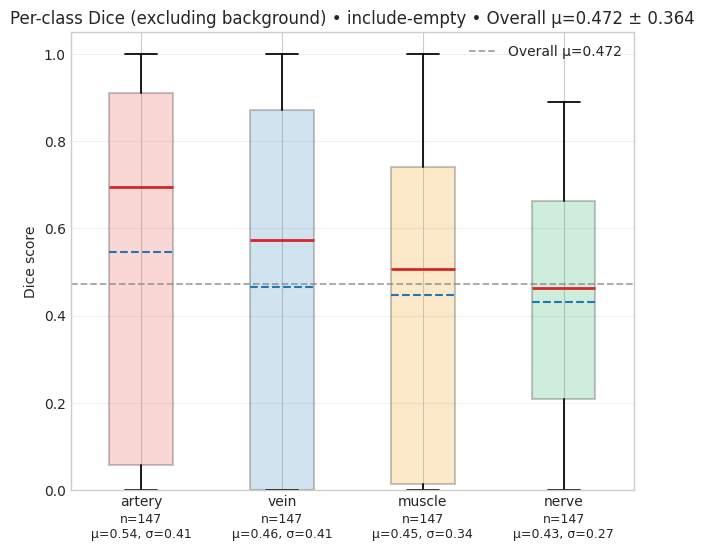

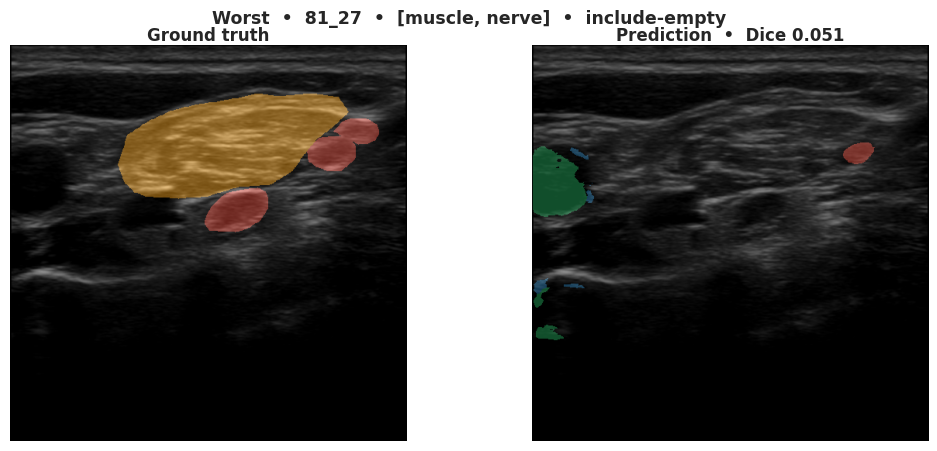

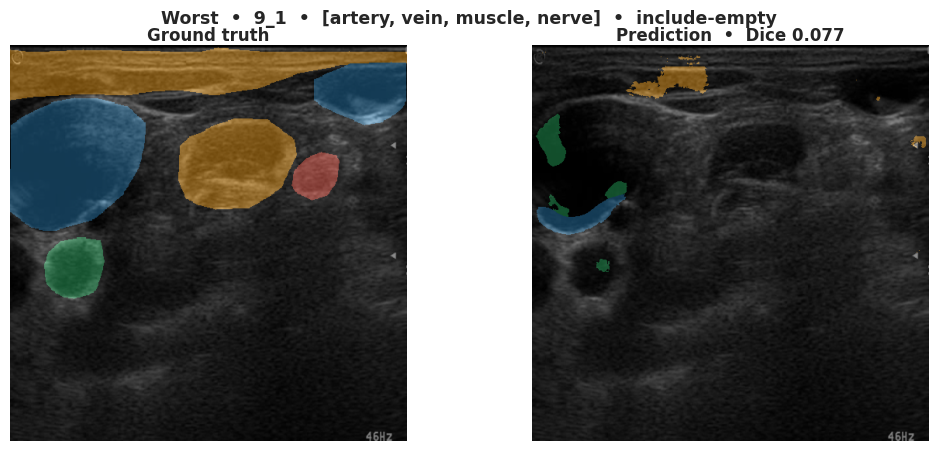

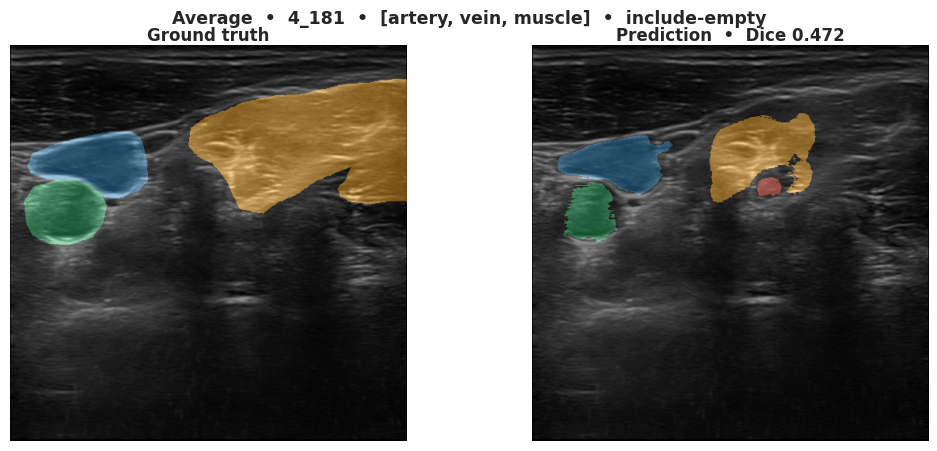

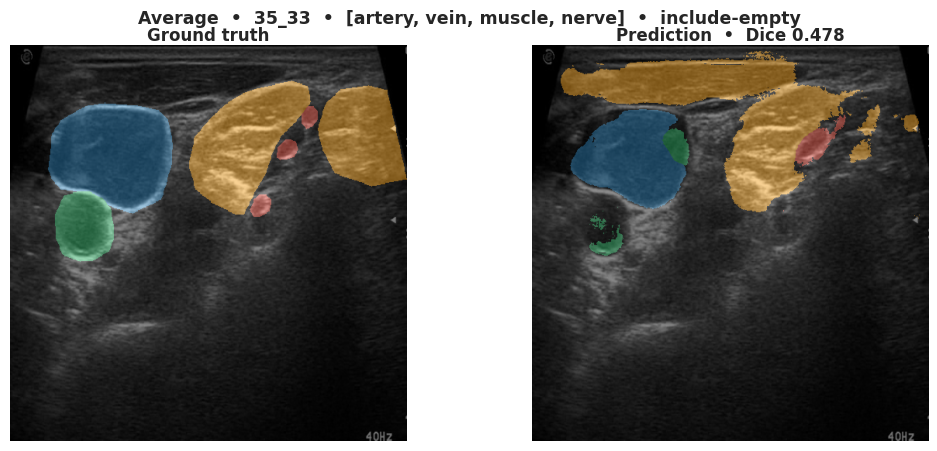

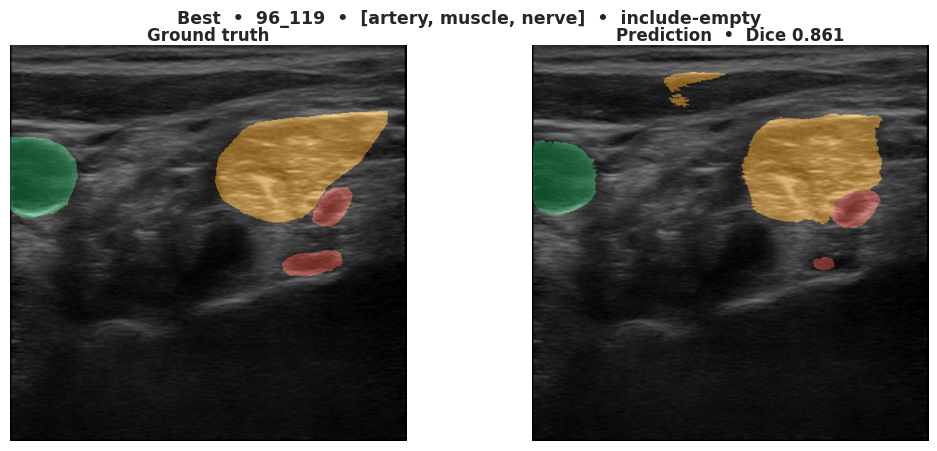

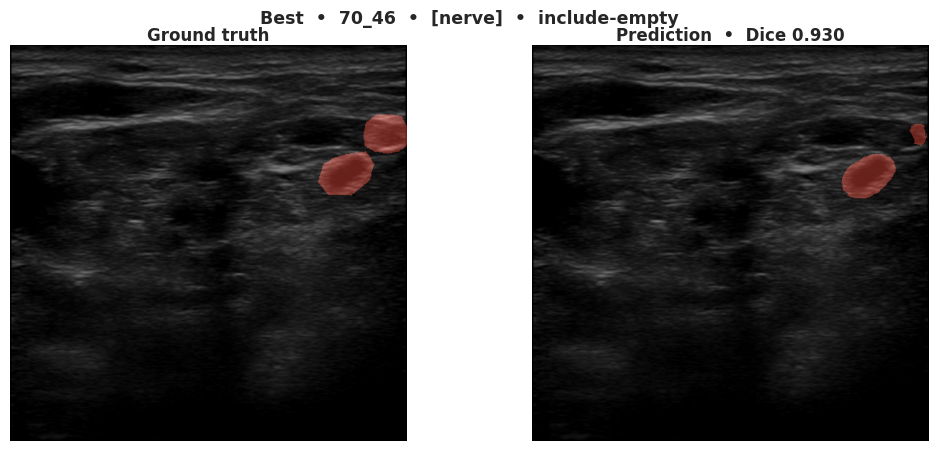

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


wandb: ERROR The nbformat package was not found. It is required to save notebook history.



📂 Fold 2/5
  Train patient IDs: [16, 37, 34, 36, 24, 10, 43, 29, 15, 14, 38, 31, 39, 23, 40, 22, 18, 28, 20, 12, 42, 7, 19, 13, 44, 61, 88, 49, 2, 71, 99, 94, 47, 48, 82, 166, 52, 76, 53, 5, 6, 89, 93, 75, 65, 63, 100, 1, 58, 83, 97, 131, 77, 78, 67, 73, 66, 92, 85, 87, 69]
  Val   patient IDs: [17, 30, 25, 41, 21, 27, 64, 86, 84, 51, 3, 79, 60, 90]

Train landmarks stat: 
Artery  present: 389/647 images
Vein    present: 408/647 images
Muscle  present: 503/647 images
Nerve   present: 607/647 images

Validation landmarks stat:
Artery  present:  91/161 images
Vein    present:  74/161 images
Muscle  present: 145/161 images
Nerve   present: 153/161 images


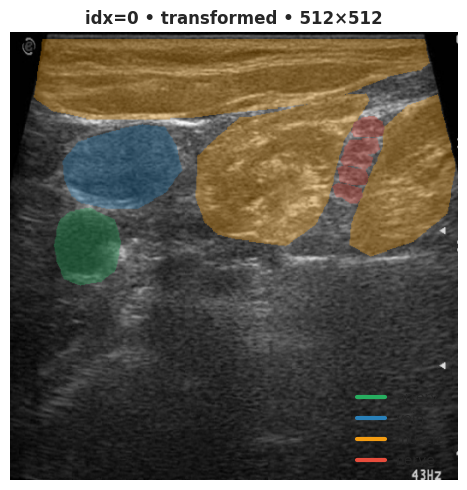

Epoch 001/100 | lr=1.000e-03 train_loss=0.9626 val_loss=0.7863 train_dice=0.0673 val_dice=0.0159 [BEST] (patience 0/20)
Epoch 002/100 | lr=1.000e-03 train_loss=0.5512 val_loss=0.6018 train_dice=0.2166 val_dice=0.2221 [BEST] (patience 0/20)
Epoch 003/100 | lr=1.000e-03 train_loss=0.4436 val_loss=0.5440 train_dice=0.2836 val_dice=0.2345 [BEST] (patience 0/20)
Epoch 004/100 | lr=1.000e-03 train_loss=0.3926 val_loss=0.4519 train_dice=0.2882 val_dice=0.2833 [BEST] (patience 0/20)
Epoch 005/100 | lr=1.000e-03 train_loss=0.3517 val_loss=0.5317 train_dice=0.2942 val_dice=0.1946  (patience 1/20)
Epoch 006/100 | lr=1.000e-03 train_loss=0.3292 val_loss=0.4640 train_dice=0.2714 val_dice=0.1677  (patience 2/20)
Epoch 007/100 | lr=1.000e-03 train_loss=0.3019 val_loss=0.5301 train_dice=0.2970 val_dice=0.1805  (patience 3/20)
Epoch 008/100 | lr=1.000e-03 train_loss=0.2783 val_loss=0.4877 train_dice=0.3521 val_dice=0.1715  (patience 4/20)
Epoch 009/100 | lr=1.000e-03 train_loss=0.2535 val_loss=0.5276 t

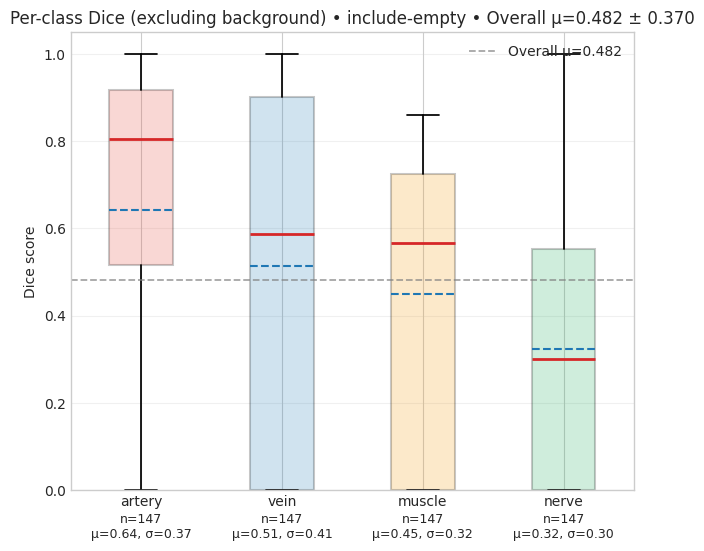

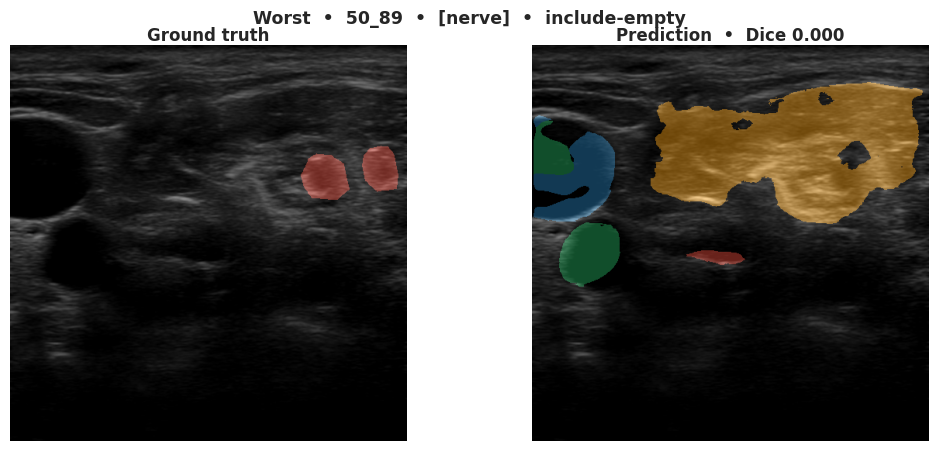

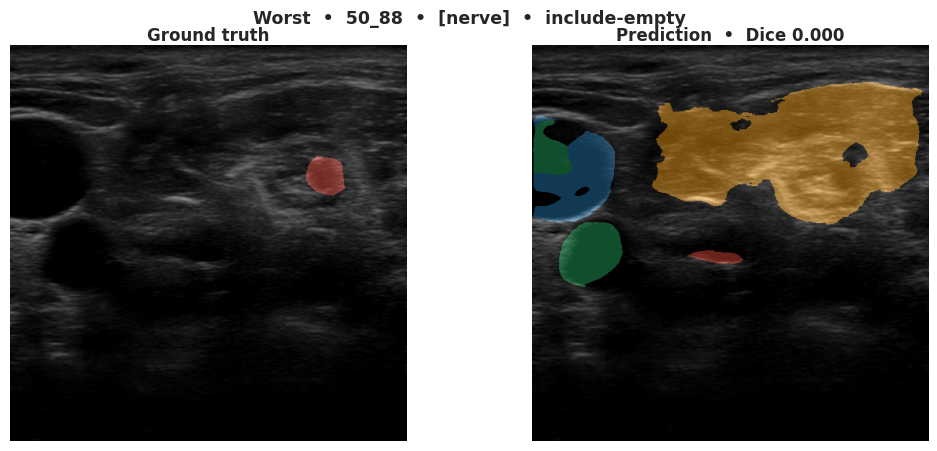

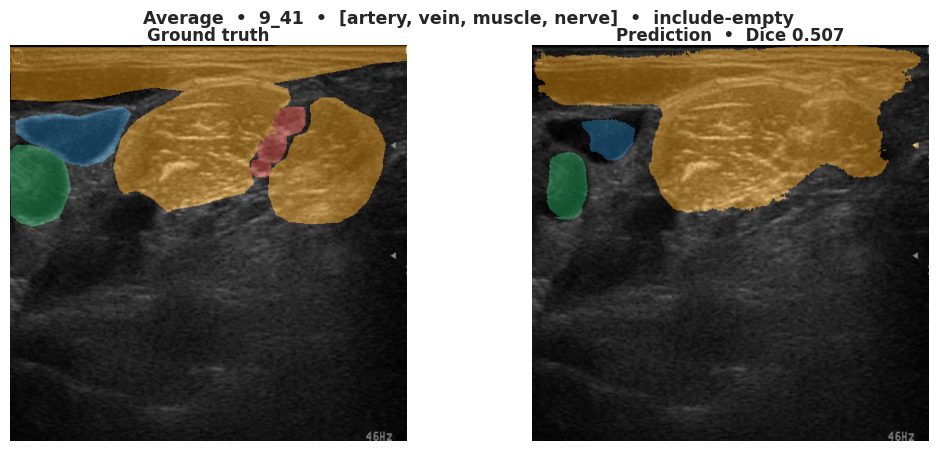

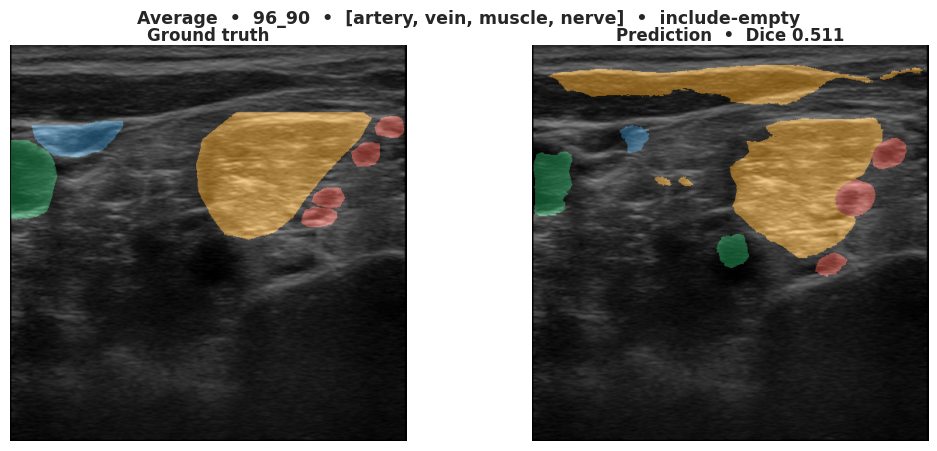

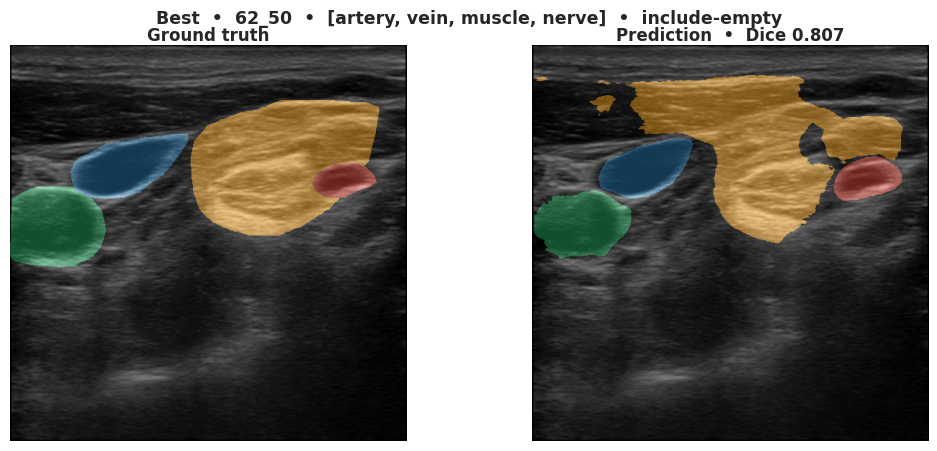

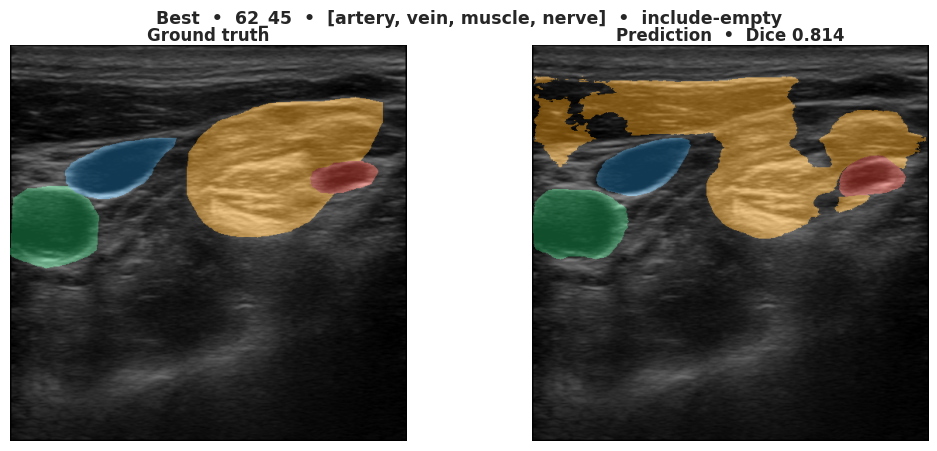

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.



📂 Fold 3/5
  Train patient IDs: [16, 37, 34, 36, 24, 10, 17, 30, 25, 41, 21, 27, 39, 23, 40, 22, 18, 28, 20, 12, 42, 7, 19, 13, 44, 61, 88, 49, 2, 71, 99, 94, 47, 64, 86, 84, 51, 3, 79, 60, 90, 89, 93, 75, 65, 63, 100, 1, 58, 83, 97, 131, 77, 78, 67, 73, 66, 92, 85, 87, 69]
  Val   patient IDs: [43, 29, 15, 14, 38, 31, 48, 82, 166, 52, 76, 53, 5, 6]

Train landmarks stat: 
Artery  present: 393/662 images
Vein    present: 403/662 images
Muscle  present: 540/662 images
Nerve   present: 624/662 images

Validation landmarks stat:
Artery  present:  87/146 images
Vein    present:  79/146 images
Muscle  present: 108/146 images
Nerve   present: 136/146 images


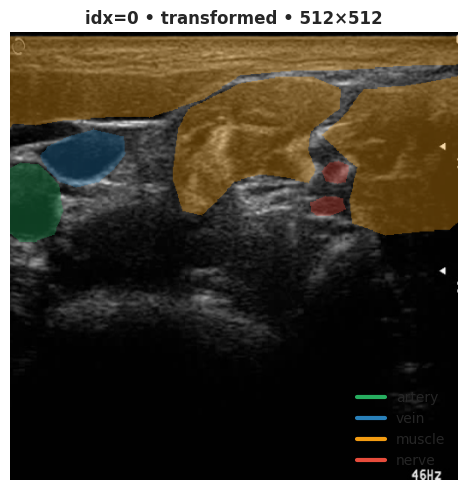

Epoch 001/100 | lr=1.000e-03 train_loss=0.8521 val_loss=0.6929 train_dice=0.1638 val_dice=0.2203 [BEST] (patience 0/20)
Epoch 002/100 | lr=1.000e-03 train_loss=0.5152 val_loss=0.5425 train_dice=0.2932 val_dice=0.3054 [BEST] (patience 0/20)
Epoch 003/100 | lr=1.000e-03 train_loss=0.4329 val_loss=0.4786 train_dice=0.3089 val_dice=0.2520 [BEST] (patience 0/20)
Epoch 004/100 | lr=1.000e-03 train_loss=0.3841 val_loss=0.4378 train_dice=0.3136 val_dice=0.1959 [BEST] (patience 0/20)
Epoch 005/100 | lr=1.000e-03 train_loss=0.3421 val_loss=0.4151 train_dice=0.3281 val_dice=0.2397 [BEST] (patience 0/20)
Epoch 006/100 | lr=1.000e-03 train_loss=0.3153 val_loss=0.3745 train_dice=0.3076 val_dice=0.1375 [BEST] (patience 0/20)
Epoch 007/100 | lr=1.000e-03 train_loss=0.2857 val_loss=0.3587 train_dice=0.3264 val_dice=0.1554 [BEST] (patience 0/20)
Epoch 008/100 | lr=1.000e-03 train_loss=0.2656 val_loss=0.3757 train_dice=0.4151 val_dice=0.2434  (patience 1/20)
Epoch 009/100 | lr=1.000e-03 train_loss=0.2490

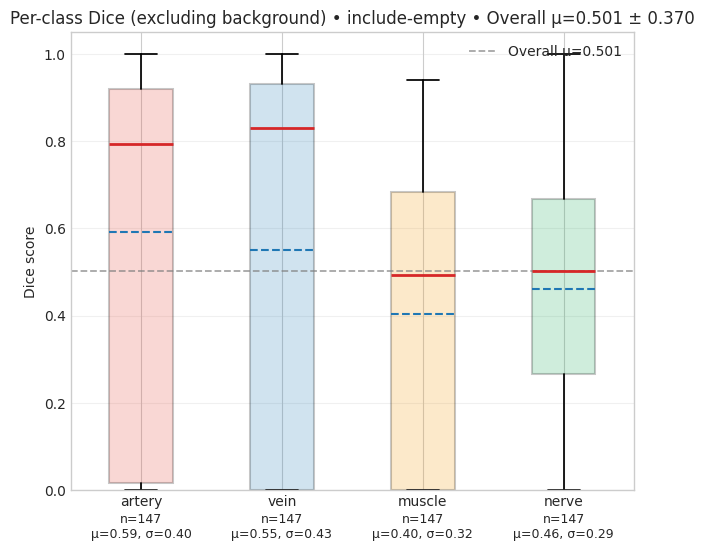

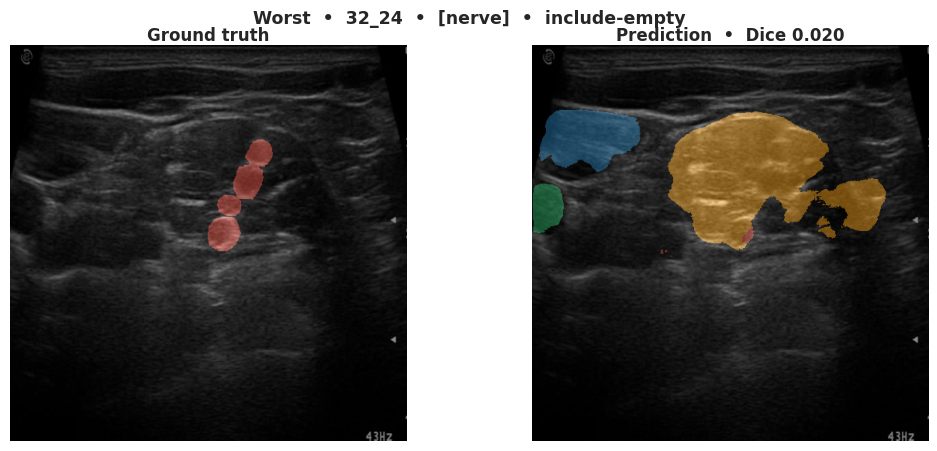

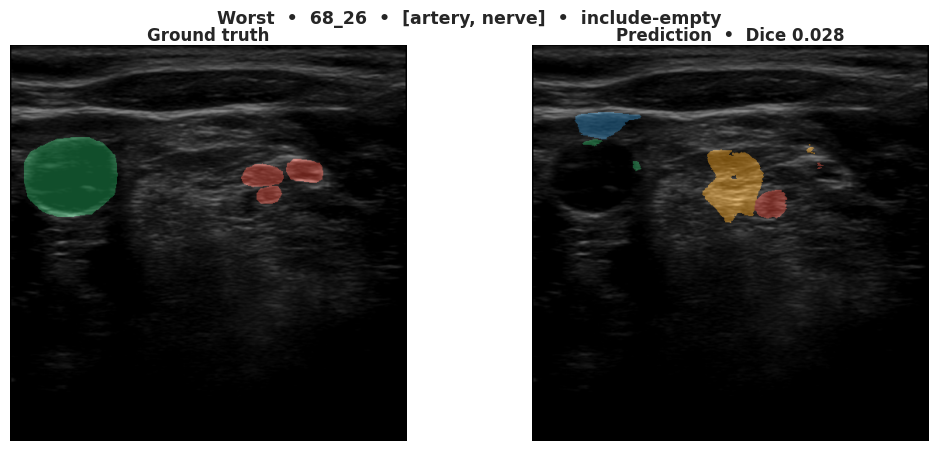

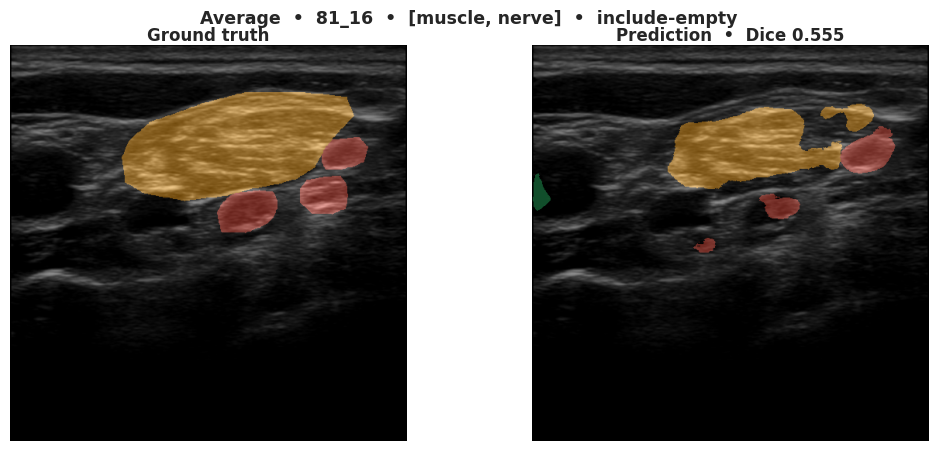

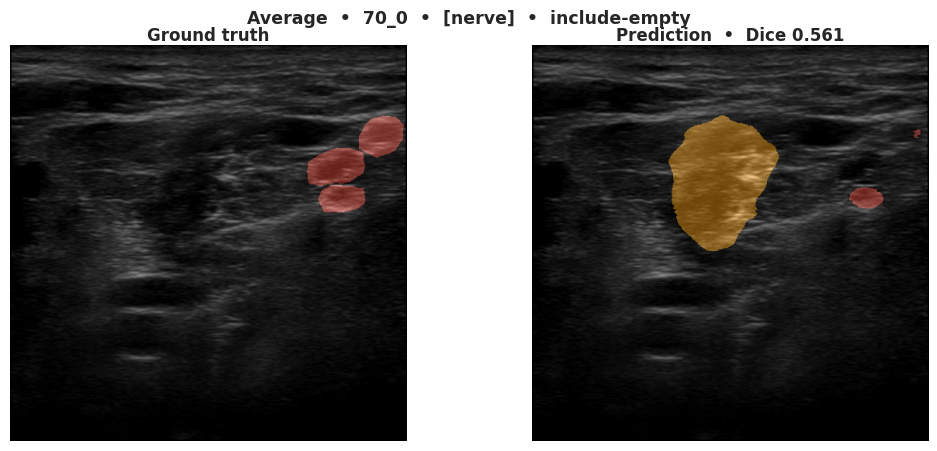

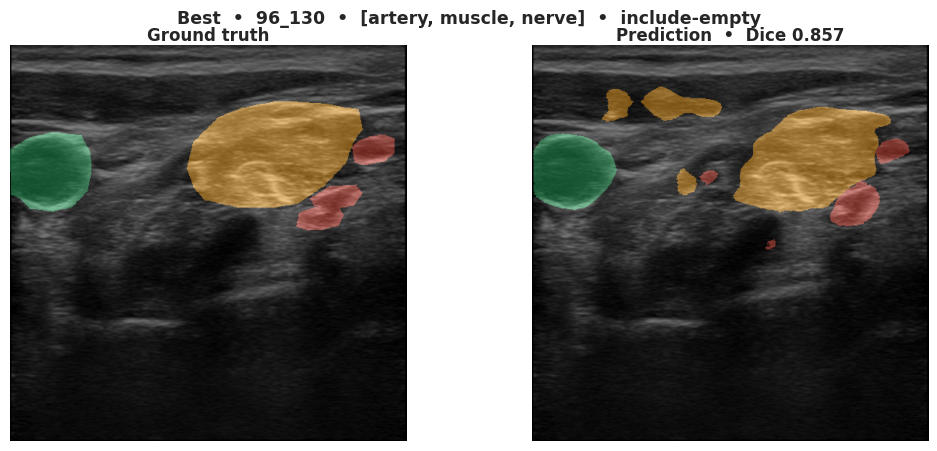

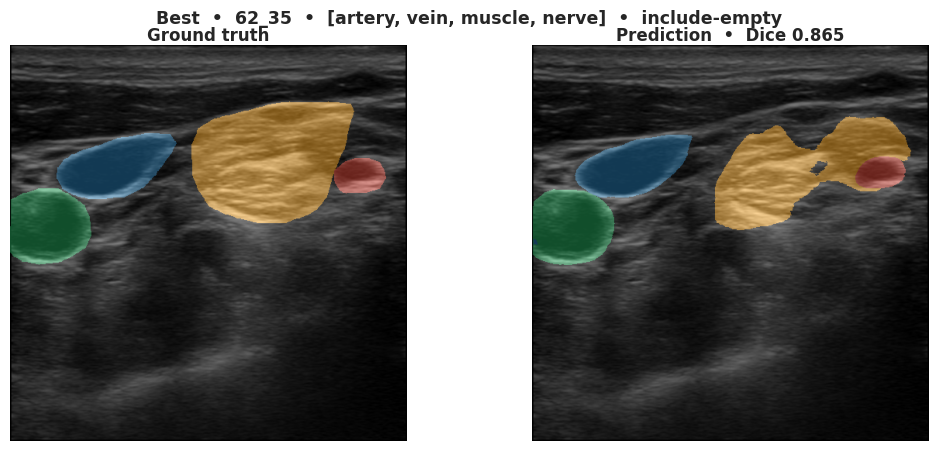

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


wandb: ERROR The nbformat package was not found. It is required to save notebook history.



📂 Fold 4/5
  Train patient IDs: [16, 37, 34, 36, 24, 10, 17, 30, 25, 41, 21, 27, 43, 29, 15, 14, 38, 31, 20, 12, 42, 7, 19, 13, 44, 61, 88, 49, 2, 71, 99, 94, 47, 64, 86, 84, 51, 3, 79, 60, 90, 48, 82, 166, 52, 76, 53, 5, 6, 83, 97, 131, 77, 78, 67, 73, 66, 92, 85, 87, 69]
  Val   patient IDs: [39, 23, 40, 22, 18, 28, 89, 93, 75, 65, 63, 100, 1, 58]

Train landmarks stat: 
Artery  present: 371/653 images
Vein    present: 362/653 images
Muscle  present: 507/653 images
Nerve   present: 611/653 images

Validation landmarks stat:
Artery  present: 109/155 images
Vein    present: 120/155 images
Muscle  present: 141/155 images
Nerve   present: 149/155 images


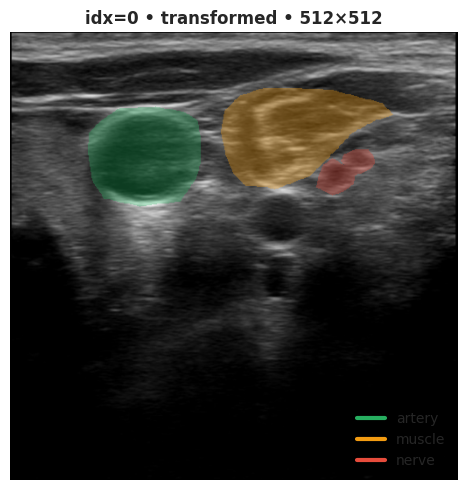

Epoch 001/100 | lr=1.000e-03 train_loss=1.0442 val_loss=0.7150 train_dice=0.0785 val_dice=0.1032 [BEST] (patience 0/20)
Epoch 002/100 | lr=1.000e-03 train_loss=0.5853 val_loss=0.6060 train_dice=0.2283 val_dice=0.1981 [BEST] (patience 0/20)
Epoch 003/100 | lr=1.000e-03 train_loss=0.4707 val_loss=0.4998 train_dice=0.2845 val_dice=0.1617 [BEST] (patience 0/20)
Epoch 004/100 | lr=1.000e-03 train_loss=0.4055 val_loss=0.4511 train_dice=0.3067 val_dice=0.1690 [BEST] (patience 0/20)


In [ ]:
res = experiment(variants, exp_id=909994, seed=seed)